In [44]:
cross_validation (X_train, y_train,
                  pipe_load,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.846537,0.085000,0.790398,-1.241093e+07,-2017.386741,-30401.612441
1,0.709402,0.054001,0.774743,-1.456428e+07,-2136.713533,-38500.768816
2,0.622194,0.053994,0.776059,-1.374827e+07,-2064.469015,-39306.882803
3,0.688007,0.039995,0.763919,-1.410005e+07,-2135.044564,-28615.533456
4,0.734002,0.042005,0.756182,-1.427912e+07,-2075.618844,-40513.504911




test_R2      7.722601e-01
test_-MSE   -1.382053e+07
test_-MAE   -2.085847e+03
test_-Max   -3.546766e+04
dtype: float64


In [5]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего


# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

import warnings
warnings.filterwarnings('ignore')

DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_clean.csv', delimiter = ',')

#Список числовых и категориальных данных

cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

#Предварительная обработка из предыдущего блокнота
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy
    
num_pipe_distance = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', StandardScaler())
])

num_distance = ['Distance']

num_pipe_engine = Pipeline([
    ('scaler', StandardScaler())
])

num_engine = ['Engine_capacity(cm3)']

num_pipe_year = Pipeline([
    ('power', PowerTransformer())
])

num_year = ['Year']

cat_pipe_transmission = Pipeline([
    ('encoder', OrdinalEncoder())

])

cat_transmission = ['Transmission']

cat_pipe_style_fuel = Pipeline([
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))

])

cat_style_fuel = ['Style', 'Fuel_type']

cat_pipe_make = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_make = ['Make']

cat_pipe_model = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat_model = ['Model']

# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
])

# и Pipeline со всеми признаками
preprocessors_all = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make', cat_pipe_make, cat_make),
    ('cat_model', cat_pipe_model, cat_model),
])

# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns_num = np.hstack([num_distance,
                    num_engine,
                    num_year,])

In [7]:
from sklearn.linear_model import SGDRegressor # Линейная регрессия с градиентным спуском от scikit-learn

from sklearn.model_selection import train_test_split#  функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

#Считываем данные, разбиваем на тестовую и тренировочную
# не забываем удалить целевую переменную цену из признаков
X,y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']

# разбиваем на тестовую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [9]:
#Оценим модель с использованием только числовых данных
# Сначала обучаем на тренировочных данных
X_train_prep = preprocessors_num.fit_transform(X_train)
# потом на валидационной
X_val_prep = preprocessors_num.transform(X_val)

#Обучаем модель
model = SGDRegressor(random_state = 42)
model.fit(X_train_prep, y_train);


In [11]:
#Подготовим несколько функций для анализа обученной модели

#вытаскивание коэффициентов из модели
def get_coefs (model):
    """Берем веса как атрибуты обученной модели.
    Входные переменные:
    ===========
    model: обученная модель
    """
    B0=model.intercept_[0]
    B=model.coef_
    return B0, B

#написание модели
def print_model (B0,B,features_names):
    """Написание уравнения модели.
    Входные переменные:
    ===========
    B0: смещение (независимый коэффициент)
    weights: веса признаков
    features_names: список названий признаков
    """
    line='{:.3f}'.format(B0)
    sign=['+','-']
    for p,(fn,b) in enumerate(zip(features_names,B)):
        line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

    print('Решение')
    print(line)
    
#визуализации весов в виде столбчатых диаграмм
def vis_weigths(weights,features_names = None):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    """
    numbers = np.arange(0,len(weights))                 # создаем массив от 0 до количество весов-1
    if features_names:
        tick_labels = np.hstack(['B0',features_names])
    else:
        tick_labels = ['B'+str(num) for num in numbers] # создаем "названия" весов
    cc=['']*len(numbers)                                # сюда будем складывать цвет в который будем подкрашивать
    for n,val in enumerate(weights):                    #перебираем все веса
        if val<0:                                       # если отрицательный вес - то красный
            cc[n]='red'
        elif val>=0:                                    # если положительный - то синий
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)  # рисуем столбчатую диаграмму. с разными цветами
    plt.xticks(np.arange(0,len(weights)),tick_labels,   #подписи к столбцам
               rotation = 45);
    

In [12]:
#Напишем уравнение модели
B0, B = get_coefs(model)
features_name = list(columns_num)
print_model(B0,B,features_name)

Решение
9014.373-874.50*Distance+2984.62*Engine_capacity(cm3)+4807.24*Year


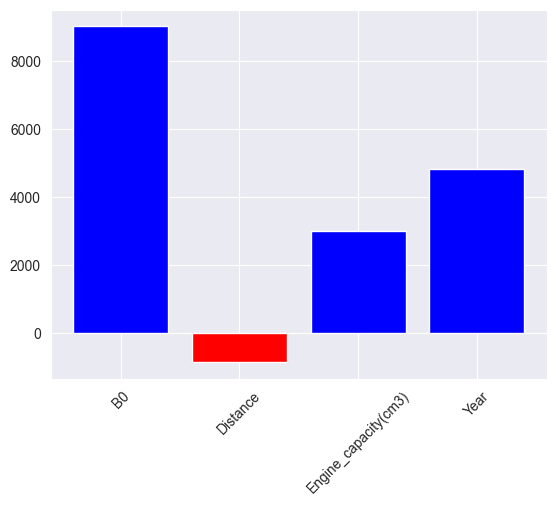

In [13]:
#Визуализируем веса в виде столбчатых диаграмм
BS = np.hstack([B0,B])
vis_weigths(BS,features_name)

In [14]:
#Оценка метрик
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)


In [16]:
print(f"r2 на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.5419
r2 на валидационной выборке: 0.5379
mse на тренировочной выборке: 27853457.5427
mse на валидационной выборке: 29091958.0937


In [17]:
#Кросс-валидация
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [19]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}
cross_validation (X_train_prep, y_train,
                  model,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.027988,0.003215,0.545649,-2.690292e+07,-3539.678476,-37681.515095
1,0.036009,0.002996,0.556572,-2.867041e+07,-3629.150133,-42203.529250
2,0.061237,0.002993,0.552150,-2.749462e+07,-3506.567818,-39917.892950
3,0.028540,0.003000,0.518209,-2.877513e+07,-3618.395237,-29616.446143
4,0.041445,0.003496,0.531088,-2.746163e+07,-3448.223397,-42112.667418




test_R2      5.407338e-01
test_-MSE   -2.786094e+07
test_-MAE   -3.548403e+03
test_-Max   -3.830641e+04
dtype: float64


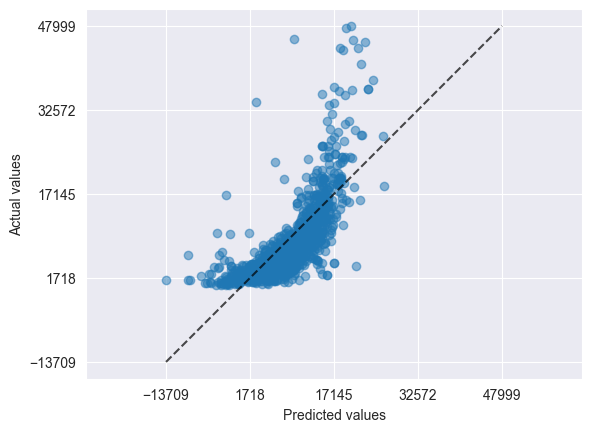

In [20]:
#Визуализация ошибок от scikit-learn
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

In [23]:
#Объединяем Pipeline Предобработки и Модель
pipe_num = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', SGDRegressor(random_state = 42))
])
pipe_num.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year'])])),
                ('model', SGDRegressor(random_state=42))])

In [24]:
B0, B = get_coefs(pipe_num['model'])
features_names = list(columns_num)

print_model (B0,B,features_names)

Решение
9014.373-874.50*Distance+2984.62*Engine_capacity(cm3)+4807.24*Year


In [25]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.5419
r2 на валидационной выборке: 0.5379
mse на тренировочной выборке: 27853457.5427
mse на валидационной выборке: 29091958.0937


In [26]:
cross_validation (X_train, y_train,
                  pipe_num,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.117997,0.012004,0.545952,-2.688503e+07,-3542.960738,-37684.488178
1,0.126595,0.021000,0.556581,-2.866982e+07,-3629.013665,-42209.556514
2,0.186002,0.015003,0.555547,-2.728605e+07,-3507.779068,-39915.551392
3,0.158999,0.012005,0.518215,-2.877477e+07,-3618.228316,-29615.840045
4,0.126998,0.011001,0.531079,-2.746213e+07,-3448.365506,-42114.191910




test_R2      5.414750e-01
test_-MSE   -2.781556e+07
test_-MAE   -3.549269e+03
test_-Max   -3.830793e+04
dtype: float64


In [28]:
#Оценим влияние предварительной обработки целевой переменной
from sklearn.compose import TransformedTargetRegressor

pipe_num_transform = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

pipe_num_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

In [29]:
B0, B = get_coefs(pipe_num_transform['model'].regressor_)
features_names = list(columns_num)

print_model (B0,B,features_names)

Решение
-0.003-0.03*Distance+0.34*Engine_capacity(cm3)+0.77*Year


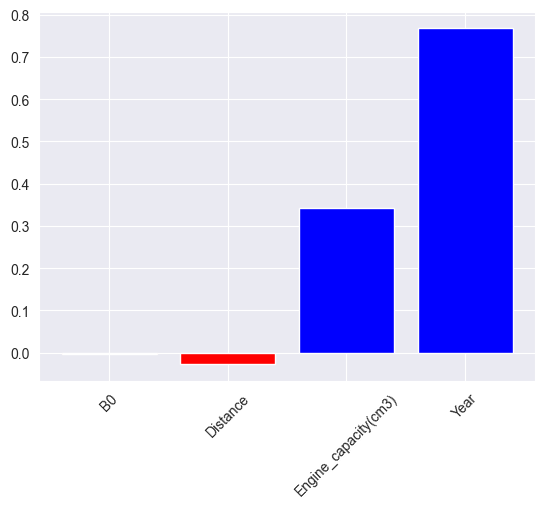

In [30]:
Bs = np.hstack([B0,B])
vis_weigths(Bs,features_names)

In [31]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_num_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_num_transform, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.6350
r2 на валидационной выборке: 0.6320
mse на тренировочной выборке: 22194996.0305
mse на валидационной выборке: 23166227.2505


In [32]:
cross_validation (X_train, y_train,
                  pipe_num_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.156000,0.015002,0.648332,-2.082287e+07,-2722.564983,-38575.837002
1,0.154999,0.010999,0.660928,-2.192316e+07,-2779.283250,-38783.589818
2,0.191001,0.022000,0.651674,-2.138462e+07,-2741.044103,-39739.329232
3,0.228001,0.017999,0.634608,-2.182320e+07,-2807.242628,-30102.066990
4,0.200999,0.016007,0.636800,-2.127066e+07,-2694.874840,-42248.084176




test_R2      6.464682e-01
test_-MSE   -2.144490e+07
test_-MAE   -2.749002e+03
test_-Max   -3.788978e+04
dtype: float64


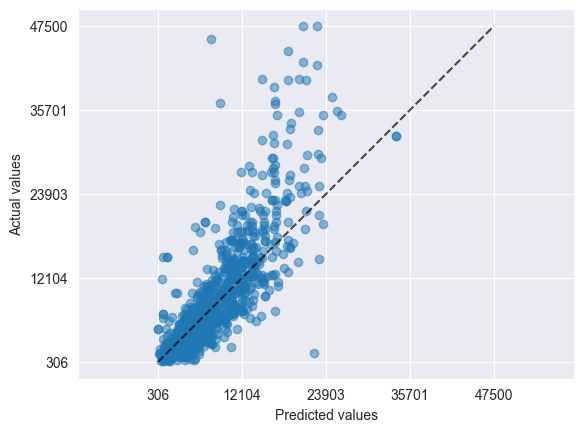

In [33]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_num_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

In [34]:
#Оценим влияние категориальных признаков
pipe_all_transform = Pipeline([
    ('preprocessors', preprocessors_all),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

In [35]:
pipe_all_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num_distance',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Distance']),
                                                 ('num_engine',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Engine_capacity(cm3)']),
                                                 ('num_year',
                                                  Pipeline(steps=[('power',
                                                                   PowerTransformer())]),
                                                  ['Year']),
                                                 ('ca...
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make']),
                                                 ('cat_model',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.0001)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Model'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

In [36]:
cat_style_fuel_names = pipe_all_transform['preprocessors'].transformers_[4][1]['encoder'].get_feature_names_out(cat_style_fuel)
cat_make_names =  pipe_all_transform['preprocessors'].transformers_[5][1]['encoder'].get_feature_names_out(cat_make)
cat_model_names =  pipe_all_transform['preprocessors'].transformers_[6][1]['encoder'].get_feature_names_out(cat_model)

# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([num_distance,
                    num_engine,
                    num_year,
                    cat_transmission,
                    cat_style_fuel_names,
                    cat_make_names,
                    cat_model_names])

In [37]:
B0, B = get_coefs(pipe_all_transform['model'].regressor_)
features_names = list(columns)

print_model (B0,B,features_names)

Решение
0.124-0.02*Distance+0.13*Engine_capacity(cm3)+0.69*Year-0.22*Transmission+0.05*Style_Cabriolet-0.14*Style_Combi-0.04*Style_Coupe+0.27*Style_Crossover-0.19*Style_Hatchback-0.03*Style_Microvan-0.07*Style_Minivan+0.11*Style_Pickup-0.01*Style_Roadster+0.31*Style_SUV-0.05*Style_Sedan-0.10*Style_Universal-0.05*Fuel_type_Diesel+0.25*Fuel_type_Electric-0.04*Fuel_type_Hybrid-0.09*Fuel_type_Metan/Propan-0.09*Fuel_type_Petrol+0.14*Fuel_type_Plug-in Hybrid-0.00*Make_Alfa Romeo+0.31*Make_Audi+0.36*Make_BMW-0.25*Make_Chevrolet-0.05*Make_Chrysler-0.24*Make_Citroen-0.33*Make_Dacia-0.22*Make_Daewoo-0.01*Make_Dodge-0.13*Make_Fiat-0.12*Make_Ford+0.05*Make_Honda-0.06*Make_Hyundai+0.05*Make_Infiniti+0.10*Make_Jaguar-0.03*Make_Jeep-0.08*Make_KIA+0.14*Make_Land Rover+0.34*Make_Lexus+0.03*Make_Lincoln-0.07*Make_Mazda+0.37*Make_Mercedes+0.05*Make_Mini-0.06*Make_Mitsubishi-0.09*Make_Nissan-0.06*Make_Opel+0.19*Make_Other-0.19*Make_Peugeot+0.29*Make_Porsche-0.17*Make_Rare-0.19*Make_Renault-0.10*Make_Rover

In [38]:
#Модификация функции для отрисовки весов
def vis_weigths_threshold(weights, feature_names, threshold):
    """Отрисовка весов с фильтром.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    threshold: порог "значимости" коэффициентов
    """
    # фильтруем веса коэффициентов
    mask = np.abs(weights) >= threshold
    weights_filtered = weights[mask]
    feature_names_filtered = [name for name, m in zip(feature_names, mask) if m]

    # Рисуем столбчатую диаграмму
    colors = np.where(weights_filtered > 0, 'b', 'r')
    plt.bar(feature_names_filtered, weights_filtered, color=colors)
    plt.xticks(rotation = 90);
    plt.axhline(0, color='k')
    plt.xlabel('признак')
    plt.ylabel('коэффициент')

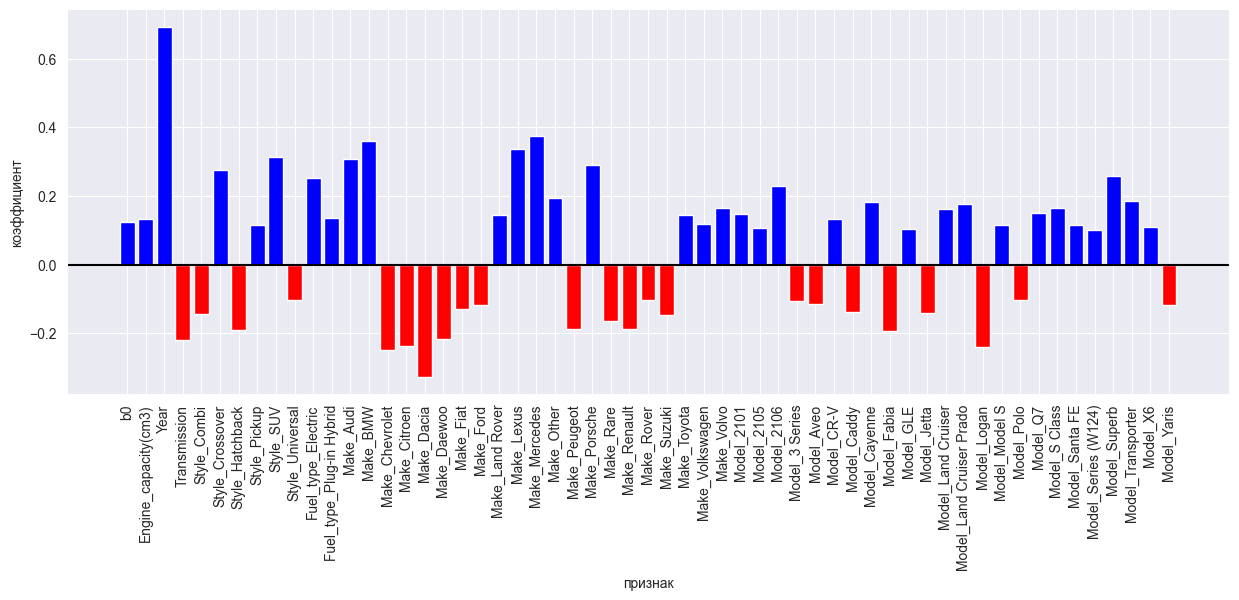

In [39]:
Bs = np.hstack([B0,B])
columns_ = np.append('b0',columns)
fig = plt.figure(figsize = (15,5))
vis_weigths_threshold(Bs,columns_, 0.1)

In [40]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.7738
r2 на валидационной выборке: 0.7716
mse на тренировочной выборке: 13752252.8730
mse на валидационной выборке: 14377145.2788


In [41]:
cross_validation (X_train, y_train,
                  pipe_all_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.828404,0.039997,0.790398,-1.241093e+07,-2017.386741,-30401.612441
1,0.655996,0.047004,0.774743,-1.456428e+07,-2136.713533,-38500.768816
2,0.679256,0.038995,0.776059,-1.374827e+07,-2064.469015,-39306.882803
3,0.717996,0.041004,0.763919,-1.410005e+07,-2135.044564,-28615.533456
4,0.676000,0.037000,0.756182,-1.427912e+07,-2075.618844,-40513.504911




test_R2      7.722601e-01
test_-MSE   -1.382053e+07
test_-MAE   -2.085847e+03
test_-Max   -3.546766e+04
dtype: float64


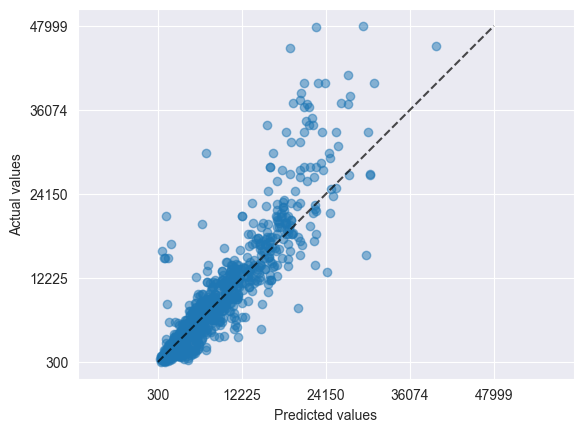

In [42]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_all_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

In [43]:
#Про то как Сохранять Модель
from joblib import dump, load # в scikit-learn ничего такого особенного нет
# пользуемся joblib
dump(model, 'model.joblib')  # чтобы сохранить объект
dump(pipe_num, 'pipe_num.joblib')  # чтобы сохранить объект
dump(pipe_num_transform, 'pipe_num_transform.joblib')  # чтобы сохранить объект
dump(pipe_all_transform, 'pipe_all_transform.joblib')  # чтобы сохранить объект
pipe_load = load('pipe_all_transform.joblib')  # чтобы загрузить из файла в формате joblib

In [45]:
cross_validation (X_train, y_train,
                  pipe_load,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.810999,0.068998,0.790398,-1.241093e+07,-2017.386741,-30401.612441
1,0.682002,0.042997,0.774743,-1.456428e+07,-2136.713533,-38500.768816
2,0.637004,0.041006,0.776059,-1.374827e+07,-2064.469015,-39306.882803
3,0.682050,0.041000,0.763919,-1.410005e+07,-2135.044564,-28615.533456
4,0.710995,0.042001,0.756182,-1.427912e+07,-2075.618844,-40513.504911




test_R2      7.722601e-01
test_-MSE   -1.382053e+07
test_-MAE   -2.085847e+03
test_-Max   -3.546766e+04
dtype: float64
